In [ ]:
!pip install tensorflow.keras.wrappers -q
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.preprocessing import StandardScaler

In [ ]:
def plot_confusion_matrix(y_true, y_pred, title):
    conf_matrix = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds', xticklabels=[1, 2, 3, 4, 5], yticklabels=[1, 2, 3, 4, 5])
    plt.xlabel('Predicted Class')
    plt.ylabel('Actual Class')
    plt.title(title)
    plt.show()

In [ ]:
# Function to plot auc-roc curve
def plot_auc_roc_curve(model, X_test, y_test):
    # Predict the probabilities for the positive class
    y_prob = model.predict_proba(X_test)[:, 1]
    
    # Compute the ROC curve and ROC area
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    
    # Plot the AUC-ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

In [ ]:
combined_df = pd.read_csv("combined_data.csv")
combined_df.drop('Unnamed: 0', axis=1, inplace = True)
combined_df_null = pd.read_csv("combined_data_null.csv")
combined_df_null.drop('Unnamed: 0', axis=1, inplace = True)
full_df = pd.concat([combined_df, combined_df_null], ignore_index=True)
full_df.head()

In [ ]:
gpus = tf.config.list_physical_devices('GPU')
print(f"GPUs: {gpus}")

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(full_df.drop(columns=['target_speed', 'duration', 'english_spoken']), 
                                                    full_df['speed_class'], test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
from sklearn.model_selection import ParameterGrid
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

def create_lstm_model(units=50, optimizer='adam'):
    model = Sequential()
    model.add(LSTM(units, input_shape=(X_train.shape[1], 1)))
    model.add(Dense(5, activation='softmax'))
    model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

param_grid_lstm = {
    'units': [50, 200],
    'optimizer': ['adam', 'rmsprop'],
    'epochs': [10, 32],
    'batch_size': [32, 128]
}

best_score = 0
best_params = {}

for params in ParameterGrid(param_grid_lstm):
    lstm_clf = KerasClassifier(build_fn=create_lstm_model, **params, verbose=0)
    lstm_clf.fit(np.expand_dims(X_train, axis=2), y_train)
    score = lstm_clf.score(np.expand_dims(X_test, axis=2), y_test)
    
    if score > best_score:
        best_score = score
        best_params = params

print("Best LSTM Params:", best_params)


In [ ]:
param_grid_nn = {'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
                 'activation': ['tanh', 'relu'],
                 'solver': ['sgd', 'adam'],
                 'alpha': [0.0001, 0.05],
                 'learning_rate': ['constant','adaptive']}

nn_clf = GridSearchCV(MLPClassifier(max_iter=100), param_grid_nn, n_jobs=-1, cv=3)


In [ ]:
param_grid_rf = {'n_estimators': [100, 200, 300],
                 'max_features': ['auto', 'sqrt', 'log2'],
                 'max_depth': [4, 5, 6, 7, 8],
                 'criterion': ['gini', 'entropy']}

rf_clf = GridSearchCV(RandomForestClassifier(), param_grid_rf, n_jobs=-1, cv=3)


In [ ]:
param_grid_nb = {
    'var_smoothing': np.logspace(0, -9, num=100)
}

nb_clf = GridSearchCV(GaussianNB(), param_grid_nb, n_jobs=-1, cv=3)

nb_clf = GaussianNB()

In [ ]:
param_grid_knn = {'n_neighbors': [3, 5, 11, 19],
                  'weights': ['uniform', 'distance'],
                  'metric': ['euclidean', 'manhattan']}

knn_clf = GridSearchCV(KNeighborsClassifier(), param_grid_knn, n_jobs=-1, cv=3)

In [ ]:
models = {
    'LSTM': KerasClassifier(build_fn=create_lstm_model, **best_params, verbose=0),
    'Feedforward NN': nn_clf,
    'Random Forest': rf_clf,
    'Naive Bayes': nb_clf,
    'KNN': knn_clf
}

scores = {
    'Model': [],
    'Recall': [],
    'Precision': [],
    'F1-Score': [],
    'Accuracy': []
}

for model_name, model in models.items():
    if model_name == 'LSTM':
        X_train_lstm = np.expand_dims(X_train, axis=2)
        X_test_lstm = np.expand_dims(X_test, axis=2)
        model.fit(X_train_lstm, y_train)
        y_pred = model.predict(X_test_lstm)
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
    
    recall = recall_score(y_test, y_pred, average='macro')
    precision = precision_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')
    accuracy = accuracy_score(y_test, y_pred)
    
    scores['Model'].append(model_name)
    scores['Recall'].append(recall)
    scores['Precision'].append(precision)
    scores['F1-Score'].append(f1)
    scores['Accuracy'].append(accuracy)

scores_df = pd.DataFrame(scores)


In [ ]:
metrics = ['Recall', 'Precision', 'F1-Score', 'Accuracy']
barWidth = 0.15

r1 = np.arange(len(scores_df))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
r4 = [x + barWidth for x in r3]
r5 = [x + barWidth for x in r4]

plt.figure(figsize=(12, 8))

plt.bar(r1, scores_df['Recall'], color='blue', width=barWidth, edgecolor='grey', label='Recall')
plt.bar(r2, scores_df['Precision'], color='green', width=barWidth, edgecolor='grey', label='Precision')
plt.bar(r3, scores_df['F1-Score'], color='red', width=barWidth, edgecolor='grey', label='F1-Score')
plt.bar(r4, scores_df['Accuracy'], color='purple', width=barWidth, edgecolor='grey', label='Accuracy')

plt.xlabel('Model', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(scores_df))], scores_df['Model'])

plt.legend()
plt.show()


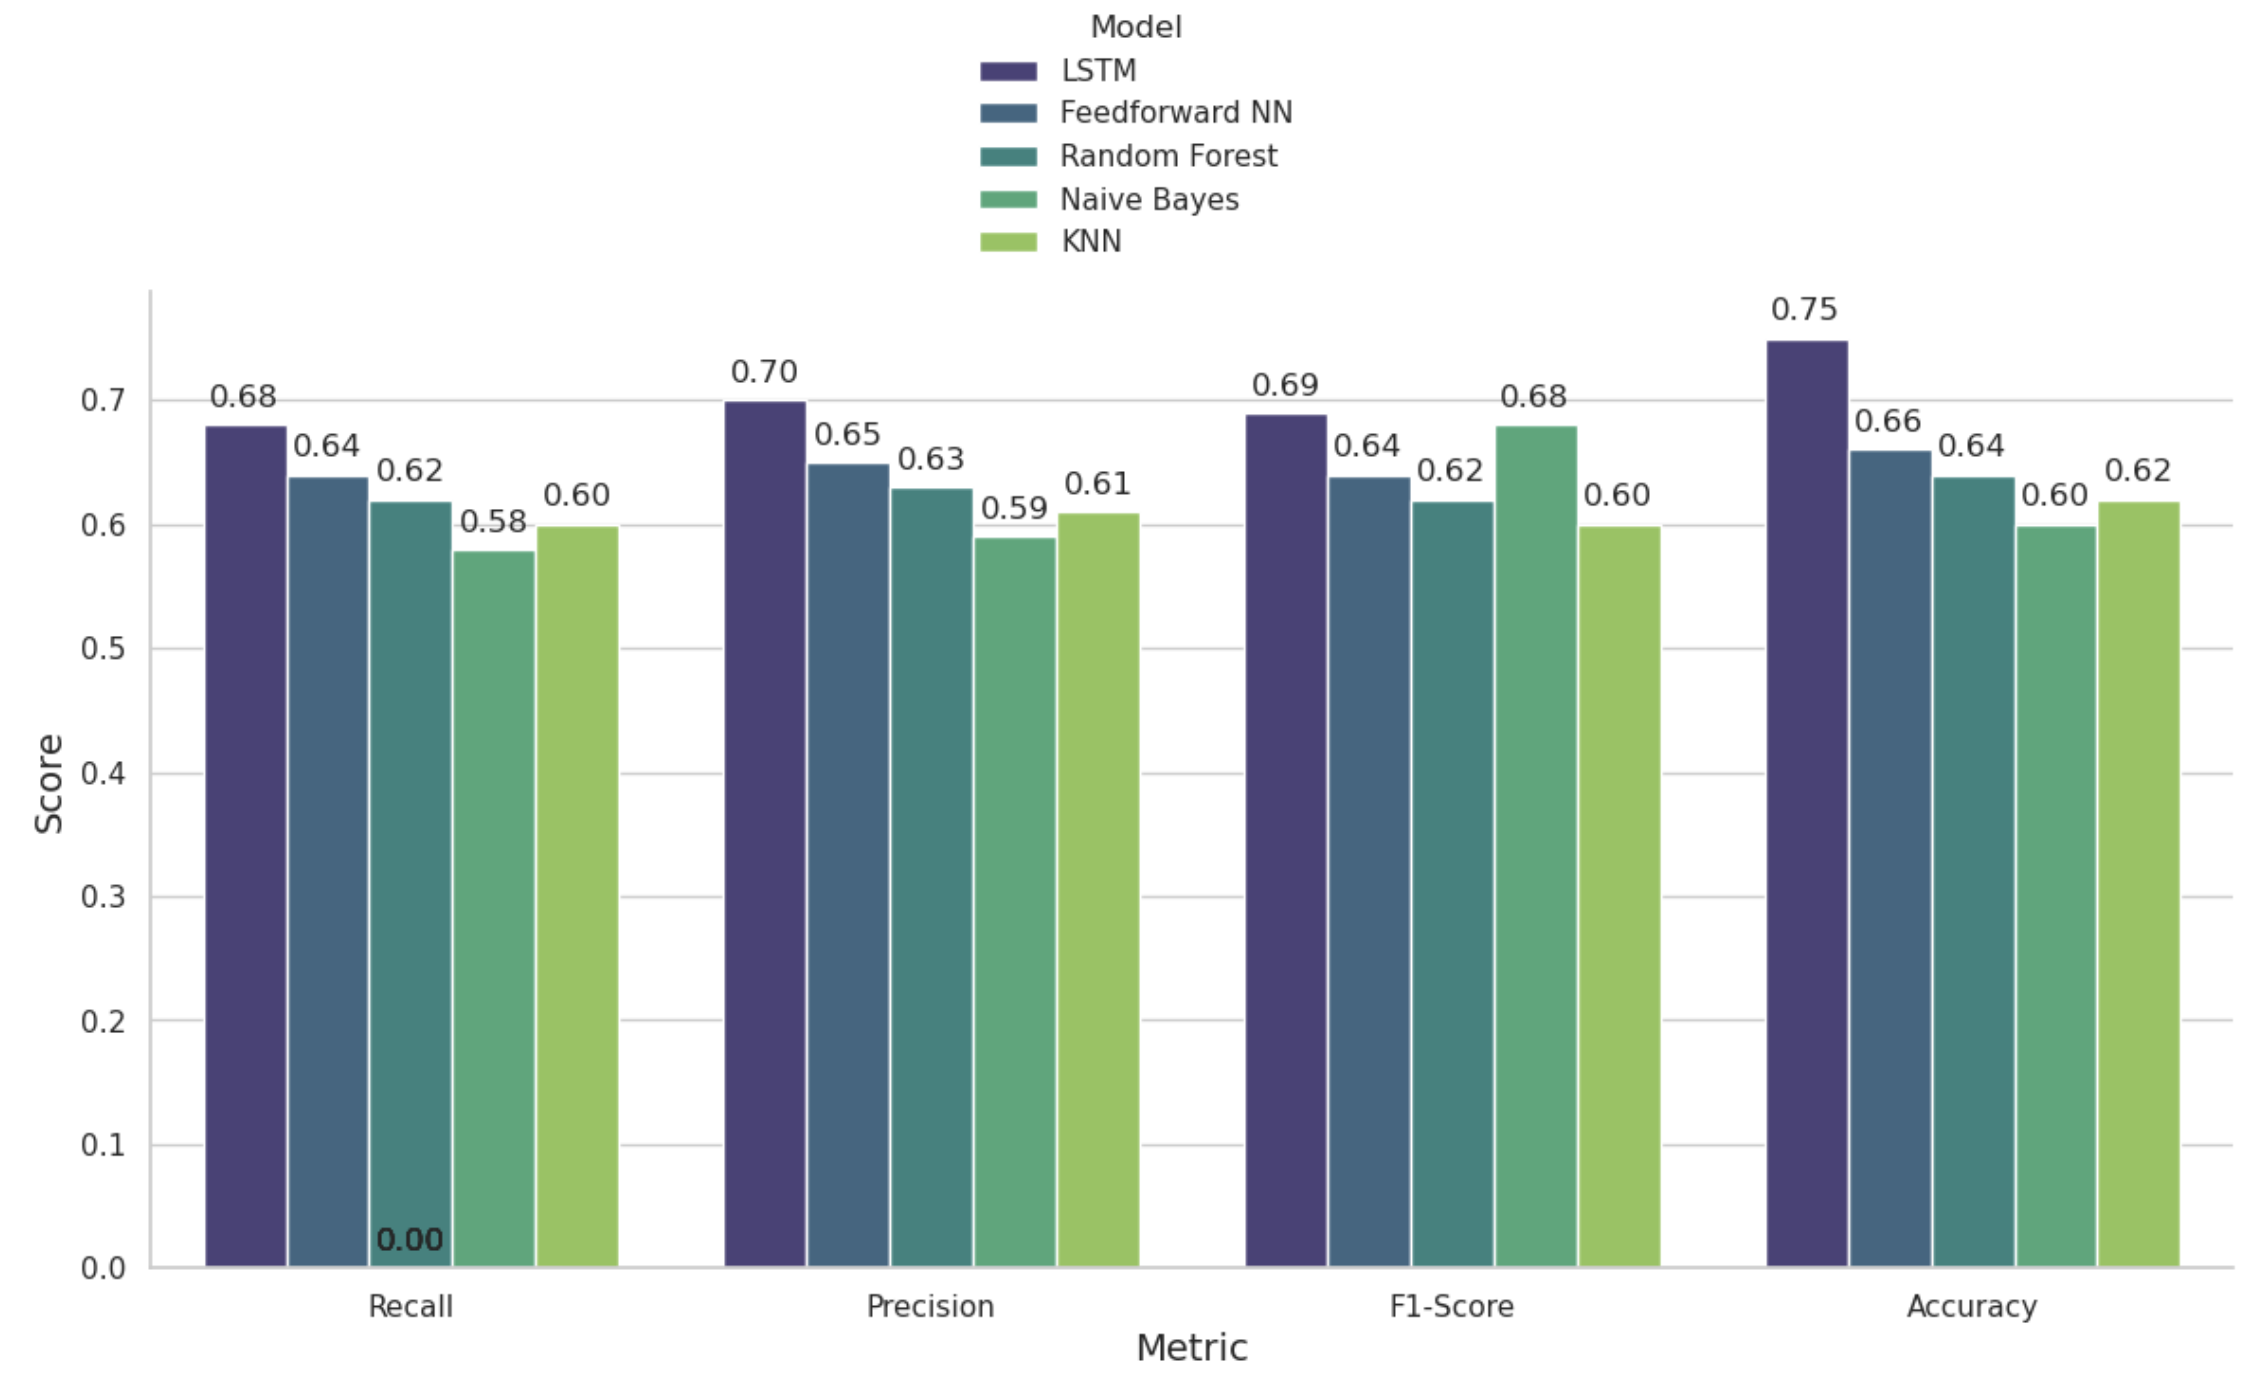